<a name = 'home'>

## Table of Contents

[1. Overview and Motivation](#1)

[2. Initial Questions](#2)

[3. Approach & Data Sources](#3)

[4. Sample Data & Analysis](#4)

[5. Data Preprocessing](#5)
- Features Selection
- Train Test Split
- categorical Data Encoding
- Data Scaling


[6. Model Training](#6)
- Random Forest
- K-Nearest Neighbors
- Logistics Regression
- Support Vector Machine
- Modeling Result

[ 7. Finding ](#7)



<a name = "1"></a>

# 1. Overview and Motivation 

Applying things learned in class into this mini project by going through the whole machine learning workflow.


<a name = "2"></a>

# 2. Initial Questions

By using flight delay records in year 2015 to predict flight which has significant delay on Jan 2016

<a name = "3"></a>

## 3. Approach & Data Sources
Getting data from kaggle with link https://www.kaggle.com/usdot/flight-delays.
Limited data to only delay flight records and only targeted on origin_airport = "San Francisco International Airport" and destination_airport = "Los Angeles International Airport"

All those actual delay reasons, Wheel off time, Air System Delay Time, Weather Delay Time & irrelevant data had been removed.


<i><b>Initial Features:</b>
<br>YEAR
<br>MONTH
<br>DAY_x
<br>AIRLINE
<br>SCHEDULED_DATE
<br>TIME_CTG

<br><i><b>Accuracy : 0.77-0.79:</b>

<br><i><b>Enhanced Features:</b>
<br>YEAR
<br>MONTH
<br>DAY_x
<br>DAY_OF_WEEK
<br>AIRLINE
<br>SCHEDULED_DEPARTURE
<br>SCHEDULED_ARRIVAL
<br>SCHEDULED_DATE
<br>SCHEDULED_DT
<br>TOTAL_DELAY
<br>TIME_CTG
<br>IS_HOLIDAY

<a name = "4"></a>

## 4. Sample Data & Analysis

<font size = 1> [home](#home) </font>

<font color='727375'><i><b>Import libraries</font>

In [48]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import datetime 

#plot
import folium
from matplotlib import cm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#preprosessing
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

#ensemble
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

#scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#pipeline
from sklearn.pipeline import Pipeline

<font color='727375'><i><b>Import source files
<br> 1. Flight
<br> 2. Airline
<br> 3. Holiday
</font>

In [49]:
%%time
print('Importing Data Start..')
print()
print('1. Import Flight Data')
#import flight data
df_flights = pd.read_csv("Flights_2.csv",
                                     low_memory=False , 
                                     dtype = {'SCHEDULED_DEPARTURE': str,
                                                 'DEPARTURE_TIME': str,
                                                 'DEPARTURE_DELAY': str,
                                                 'SCHEDULED_ARRIVAL': str,
                                                 'ARRIVAL_TIME': str,
                                                 'SCHEDULED_TIME': str,
                                                 'ARRIVAL_DELAY': str
                                                 
        })

# import airline data
print('2. Import Airline Data')
df_airlines = pd.read_csv("airlines.csv")


#---------------------------------------------------------------
# import USA_holiday data
print('3. Import Holiday Data')
df_USA_holiday = pd.read_excel("CA_HOLIDAY.xlsx")
df_USA_holiday.DATE = pd.to_datetime(df_USA_holiday['DATE'])
# df_USA_holiday = df_USA_holiday[df_USA_holiday.STATE=='SFO']

#---------------------------------------------------------------

print('Importing Data Completed..')


Importing Data Start..

1. Import Flight Data
2. Import Airline Data
3. Import Holiday Data
Importing Data Completed..
Wall time: 505 ms


In [50]:
%%time
print("Data Preprocessing Start..")
print()


# New columns SCHEDULED_DATE:
df_flights['SCHEDULED_DATE'] = pd.to_datetime(df_flights[['YEAR','MONTH','DAY']]) 

# modified schedule time format into 4 digit
df_flights.SCHEDULED_TIME = df_flights['SCHEDULED_TIME'].astype(str)
df_flights.SCHEDULED_TIME = df_flights.SCHEDULED_TIME.apply(lambda x: "0"+ x[0] + ":" + x[-2:] + ":00" if len(x)==3 else x[0:2] + ":" + x[-2:] + ":00")
df_flights.SCHEDULED_TIME.head()

# New columns SCHEDULED_DT:
df_flights['SCHEDULED_DT'] = pd.to_datetime(df_flights[['YEAR','MONTH','DAY']])  + pd.to_timedelta(df_flights.SCHEDULED_TIME)

# New column "Total Delay" : Departure Delay + Arrival Delay
df_flights['TOTAL_DELAY'] = pd.to_numeric(df_flights['DEPARTURE_DELAY']) + pd.to_numeric(df_flights['ARRIVAL_DELAY'])

# New columns TIME_CTG:
df_flights['TIME_CTG'] = df_flights['SCHEDULED_TIME'].apply(lambda x: 'Night' if x[0:2] in ['22','23','00','01','02','03'] 
                                                                     else 'Morning' if x[0:2] in ['04','05','06','07','08','09'] 
                                                                     else 'Afternoon' if x[0:2] in ['10','11','12','13','14','15']
                                                                     else 'Evening')

# New column "DELAY_TYPE" : An indicator to indicate if the flight is delayed. I classify those flights with delays > 20 minutes as 1 and <= 20 minutes as 0
df_flights['SIGNIFICANT_DELAY'] = df_flights['TOTAL_DELAY'].apply(lambda x: 0 if x<31 else 1)

df_flights = df_flights.merge(df_USA_holiday, how= 'left', left_on = 'SCHEDULED_DATE', right_on = 'DATE')
df_flights['IS_HOLIDAY'] = df_flights['DATE'].apply(lambda x: 0 if pd.isnull(x) else 1)

print("Data Preprocessing Completed")

Data Preprocessing Start..

Data Preprocessing Completed
Wall time: 1.15 s


In [51]:
#put asside dec for testing 

# df_flights_train = df_flights[df_flights.MONTH!=12]
# df_flights_test = df_flights[df_flights.MONTH==12]

df_flights_train = df_flights

In [5]:
n = folium.Map(tiles='Stamen Terrain', zoom_start=3, location=[37.619,-122.37484] )
folium.Marker(
                        location=[37.619,-122.37484],
                        popup='San Francisco International Airport',
                        icon=folium.Icon(icon='plane')
                    ).add_to(n)
folium.Marker(
                        location=[33.94254,-118.40807],
                        popup='Los Angeles International Airport',
                        icon=folium.Icon(icon='plane', color="red")
                    ).add_to(n)

n

<font color='727375'><i><b>Monthly Delay Pattern

</font>

    YEAR  MONTH  FLIGHT_CNT  DELAY_FLIGHT_CNT  DELAY_RATE
0   2015      1        2149               390    0.181480
1   2015      2        1986               375    0.188822
2   2015      3        2205               517    0.234467
3   2015      4        2189               414    0.189127
4   2015      5        2209               606    0.274332
5   2015      6        2499               629    0.251701
6   2015      7        2603               955    0.366884
7   2015      8        2791               779    0.279111
8   2015      9        2458               407    0.165582
9   2015     10        2678               427    0.159447
10  2015     11        2775               446    0.160721
11  2015     12        2645               862    0.325898


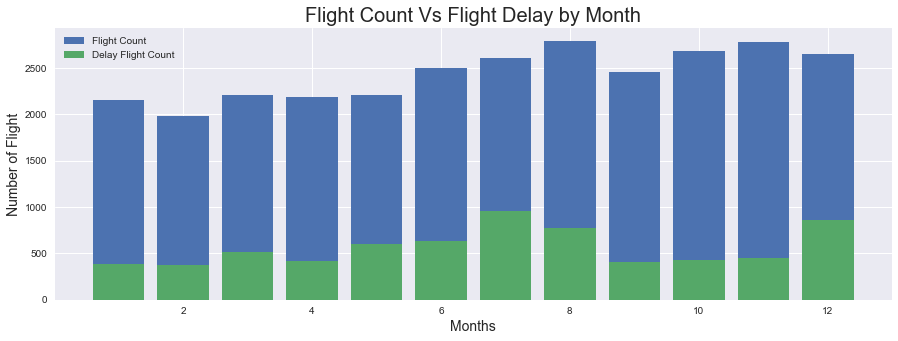

In [93]:
df_delay_time_series = df_flights_train.groupby(['YEAR','MONTH'])['ORIGIN_AIRPORT'].count().to_frame('FLIGHT_CNT')
df_delay_time_series['DELAY_FLIGHT_CNT'] = df_flights_train[df_flights_train.SIGNIFICANT_DELAY==1].groupby(['YEAR','MONTH'])['ORIGIN_AIRPORT'].count()
df_delay_time_series['DELAY_RATE'] = df_delay_time_series.DELAY_FLIGHT_CNT/df_delay_time_series.FLIGHT_CNT
df_delay_time_series = df_delay_time_series.reset_index()
print(df_delay_time_series)
plt.figure(figsize=(15,5)).add_subplot()
# ax2 = ax.twinx()
plt.bar(df_delay_time_series.MONTH, df_delay_time_series.FLIGHT_CNT)
plt.bar(df_delay_time_series.MONTH, df_delay_time_series.DELAY_FLIGHT_CNT)
# ax2.plot(df_delay_time_series.MONTH, df_delay_time_series.DELAY_FLIGHT_CNT/df_delay_time_series.FLIGHT_CNT)

plt.legend(['Flight Count','Delay Flight Count'])
plt.ylabel('Number of Flight',fontsize = 14)
plt.xlabel('Months',fontsize = 14)
plt.title('Flight Count Vs Flight Delay by Month',fontsize = 20)




   DAY_OF_WEEK  FLIGHT_CNT  DELAY_FLIGHT_CNT  Delay Rate
0            1        4400              1197    0.272045
1            2        4305               792    0.183972
2            3        4360               826    0.189450
3            4        4393              1108    0.252219
4            5        4435              1147    0.258625
5            6        3259               412    0.126419
6            7        4035              1325    0.328377


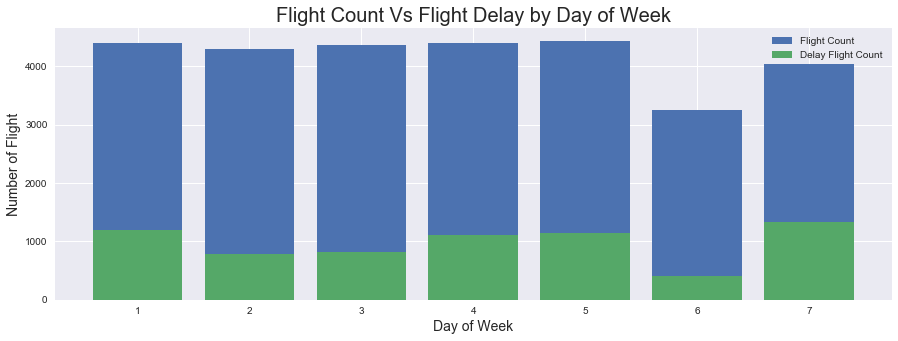

In [92]:
df_delay_time_series2 = df_flights_train.groupby(['DAY_OF_WEEK'])['ORIGIN_AIRPORT'].count().to_frame('FLIGHT_CNT')
df_delay_time_series2['DELAY_FLIGHT_CNT'] = df_flights_train[df_flights_train.SIGNIFICANT_DELAY==1].groupby(['DAY_OF_WEEK'])['ORIGIN_AIRPORT'].count()
df_delay_time_series2['Delay Rate'] = df_delay_time_series2.DELAY_FLIGHT_CNT/df_delay_time_series2.FLIGHT_CNT
df_delay_time_series2 = df_delay_time_series2.reset_index()
print(df_delay_time_series2)
plt.figure(figsize=(15,5)).add_subplot()

plt.bar(df_delay_time_series2.DAY_OF_WEEK, df_delay_time_series2.FLIGHT_CNT)
plt.bar(df_delay_time_series2.DAY_OF_WEEK, df_delay_time_series2.DELAY_FLIGHT_CNT)


plt.legend(['Flight Count','Delay Flight Count'])
plt.ylabel('Number of Flight',fontsize = 14)
plt.xlabel('Day of Week',fontsize = 14)
plt.title('Flight Count Vs Flight Delay by Day of Week',fontsize = 20)



  AIRLINE  FLIGHT_CNT  Delay_Flight  Delay Rate
0      AA        4234           798    0.188474
1      DL        3139          1088    0.346607
2      OO        1282           277    0.216069
3      UA        7669          1579    0.205894
4      VX        6676          1480    0.221690
5      WN        6187          1585    0.256182


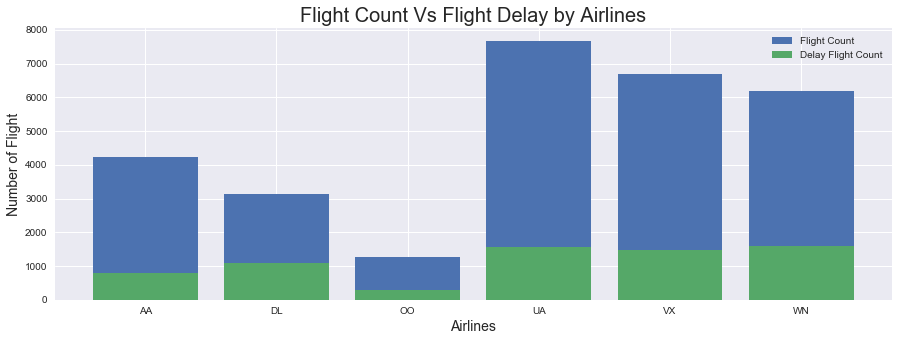

In [90]:

df_delay_airline = df_flights_train.groupby(['AIRLINE'])['AIRLINE'].count().to_frame('FLIGHT_CNT')
df_delay_airline['Delay_Flight'] = df_flights_train[df_flights_train.SIGNIFICANT_DELAY==1].groupby(['AIRLINE'])['AIRLINE'].count()
df_delay_airline['Delay Rate'] = df_delay_airline.Delay_Flight/df_delay_airline.FLIGHT_CNT
df_delay_airline = df_delay_airline.reset_index()
print(df_delay_airline)
plt.figure(figsize=(15,5)).add_subplot()

plt.bar(df_delay_airline.index, df_delay_airline.FLIGHT_CNT)
plt.bar(df_delay_airline.index, df_delay_airline.Delay_Flight)
plt.xticks(df_delay_airline.index,df_delay_airline.AIRLINE.values,fontsize = 10)

plt.legend(['Flight Count','Delay Flight Count'])
plt.ylabel('Number of Flight',fontsize = 14)
plt.xlabel('Airlines',fontsize = 14)
plt.title('Flight Count Vs Flight Delay by Airlines',fontsize = 20)


   IS_HOLIDAY  FLIGHT_CNT  Delay_Flight  Delay Rate
0           0       28384          6674    0.235132
1           1         803           133    0.165629


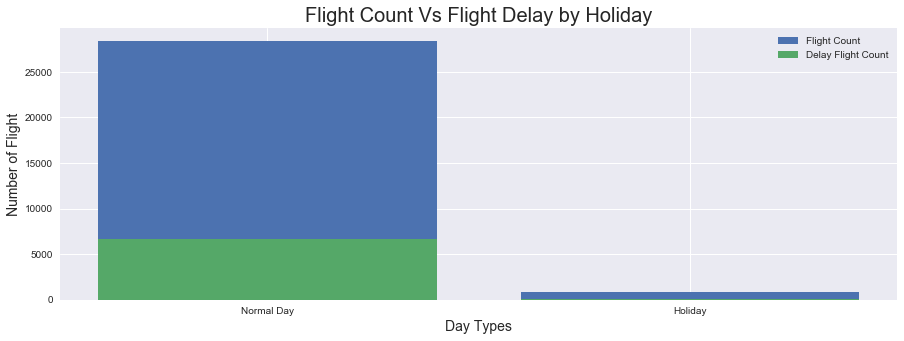

In [88]:
df_delay_holiday = df_flights_train.groupby(['IS_HOLIDAY'])['AIRLINE'].count().to_frame('FLIGHT_CNT')
df_delay_holiday['Delay_Flight'] = df_flights_train[df_flights_train.SIGNIFICANT_DELAY==1].groupby(['IS_HOLIDAY'])['AIRLINE'].count()
df_delay_holiday['Delay Rate'] = df_delay_holiday.Delay_Flight/df_delay_holiday.FLIGHT_CNT
df_delay_holiday = df_delay_holiday.reset_index()
print(df_delay_holiday)
plt.figure(figsize=(15,5)).add_subplot()

plt.bar(df_delay_holiday.index, df_delay_holiday.FLIGHT_CNT)
plt.bar(df_delay_holiday.index, df_delay_holiday.Delay_Flight)
plt.xticks(df_delay_holiday.index,['Normal Day','Holiday'],fontsize = 10)

plt.legend(['Flight Count','Delay Flight Count'])
plt.ylabel('Number of Flight',fontsize = 14)
plt.xlabel('Day Types',fontsize = 14)
plt.title('Flight Count Vs Flight Delay by Holiday',fontsize = 20)


  TIME_CTG  FLIGHT_CNT  Delay_Flight  Delay Rate
0  Evening       28016          6554    0.233938
1    Night        1171           253    0.216055


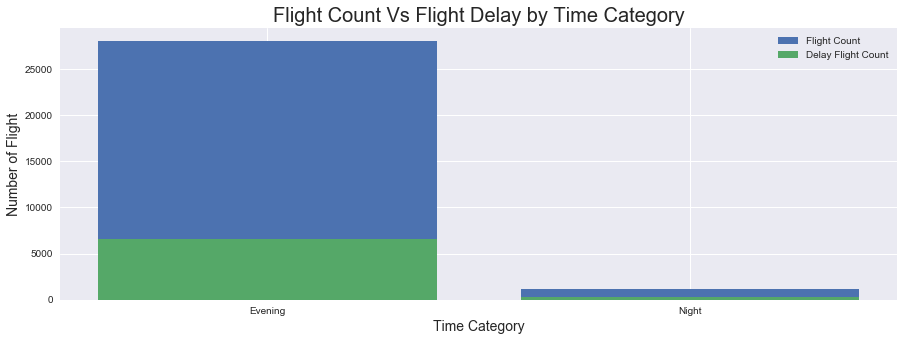

In [87]:
df_delay_time_ctg = df_flights_train.groupby(['TIME_CTG'])['AIRLINE'].count().to_frame('FLIGHT_CNT')
df_delay_time_ctg['Delay_Flight'] = df_flights_train[df_flights_train.SIGNIFICANT_DELAY==1].groupby(['TIME_CTG'])['AIRLINE'].count()
df_delay_time_ctg['Delay Rate'] = df_delay_time_ctg.Delay_Flight/df_delay_time_ctg.FLIGHT_CNT
df_delay_time_ctg = df_delay_time_ctg.reset_index()
print(df_delay_time_ctg)
plt.figure(figsize=(15,5)).add_subplot()

plt.bar(df_delay_time_ctg.index, df_delay_time_ctg.FLIGHT_CNT)
plt.bar(df_delay_time_ctg.index, df_delay_time_ctg.Delay_Flight)
plt.xticks(df_delay_time_ctg.index,df_delay_time_ctg.TIME_CTG.values,fontsize = 10)

plt.legend(['Flight Count','Delay Flight Count'])
plt.ylabel('Number of Flight',fontsize = 14)
plt.xlabel('Time Category',fontsize = 14)
plt.title('Flight Count Vs Flight Delay by Time Category',fontsize = 20)


<a name = "5"></a>

## 5. Data Preprocessing

First level of data transformation and consolidation of various data sources above were performed in python and excel. 

<font size = 1> [home](#home) </font>

In [55]:
# set X, y value
def features_selection(df):
#     X_selected_columns = ['YEAR', 'MONTH', 'DAY_x', 'AIRLINE','SCHEDULED_DATE', 'TIME_CTG']
    X_selected_columns = ['YEAR',
                        'MONTH',
                        'DAY_x',
                        'DAY_OF_WEEK',
                        'AIRLINE',
                        'SCHEDULED_DEPARTURE',
                        'SCHEDULED_ARRIVAL',
                        'SCHEDULED_DATE',
                        'SCHEDULED_DT',
                        'TOTAL_DELAY',
                        'TIME_CTG',
                        'IS_HOLIDAY']
    X = df[X_selected_columns]
    y = df['SIGNIFICANT_DELAY']    
    return X, y

In [56]:
# encode categorical variables
def encode (X):
    new_X = pd.DataFrame()
    le = preprocessing.LabelEncoder()    
    for cols in X.columns.values.tolist():
        new_X[cols] = le.fit_transform(X[cols])
    return new_X


In [57]:
#Scaled data
def scaled_data(Xtrain):
    
    X_minmax_scaled = MinMaxScaler().fit_transform(Xtrain)
    X_SC_scaled = StandardScaler().fit_transform(Xtrain)
    
   
    
    return X_minmax_scaled, X_SC_scaled

In [58]:
# Quick test on few Algorithms
def test_model(X_minmax_scaled, X_SC_scaled,y_flights_train):
    models = []
    models.append(('LogReg', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('RForest',RandomForestClassifier()))
    models.append(('SVM', SVC()))
    # evaluate each model in turn
    results = []
    results_2=[]
    names = []
    
    print("Model Testing Start...")
    print()
    for name, model in models:
        print("Model: {}".format(name))
        #with non_scaled data
        cv_results = model_selection.cross_val_score(model, X_minmax_scaled, y_flights_train, cv=cv, scoring='accuracy')
        #with scaled data
        cv_results_2 = model_selection.cross_val_score(model, X_SC_scaled, y_flights_train, cv=cv, scoring='accuracy')

        results.append(cv_results.mean())
        results_2.append(cv_results_2.mean())
        names.append(name)
        
    print()  
    print("Model Testing Completed...")
    return  pd.DataFrame({'Model':names,'Min Max Scaled':results,'Standard Scaled':results_2}, columns=['Model','Min Max Scaled', 'Standard Scaled'])
#     return re

In [59]:
# Model Training

def grid_search(X, y,models):
    
    result = []
    result2 = []
    st = []
    et = []
    print("Grid Search Function Start ..")
    print()
    for name, model, param in models:
        st.append(pd.to_datetime(datetime.datetime.now()))
        result_name = name
        
        name = model
        name  = GridSearchCV(name, param, scoring='accuracy')
        name.fit(X,y)        
        result.append(result_name)
        result2.append(name.best_params_)
        print('Model : {}; best_params :{}'.format(result_name, name.best_params_))
        et.append(pd.to_datetime(datetime.datetime.now()))    
    print()
    print("Grid Search Function End ..")
    return  pd.DataFrame({'Model':result,'Best Param':result2,'Start Time':st, 'End Time':et}, columns=['Model','Best Param','Start Time', 'End Time'])



In [60]:
def train_model(X, X2, y, y2,models):
    nm = []
    acs = []
    ps = []
    rs = []
    f1s = []
    ras = []
    st = []
    et = []
    mdl = []
    result_name = ''
    print("Model Training Start ..")
    print()
        

    for name, model in models:
        print('Model : {}'.format(name))
        result_name = name
        nm.append(result_name)
        st.append(pd.to_datetime(datetime.datetime.now()))
        
        fit_model = model.fit(X, y)
        yfit = fit_model.predict(X2)
        
        acs.append(accuracy_score(y2, yfit))
        ps.append(precision_score(y2, yfit))
        rs.append(recall_score(y2, yfit))
        f1s.append(f1_score(y2, yfit))
        ras.append(roc_auc_score(y2, yfit))
        et.append(pd.to_datetime(datetime.datetime.now()))
        mdl.append(model)
#     return
    print()
    print("Model Training End ..")

    return  pd.DataFrame({'Model Name':nm,
                         'Accuracy Score':acs,
                         'Precision Score':ps,
                         'Recall_Score':rs,
                         'F1 Score':f1s,
                         'ROC AUC Score':ras,
                         'Start Time':st, 
                         'End Time':et,
                         'Model':mdl}, columns=['Model Name',
                                                        'Accuracy Score',
                                                                  'Precision Score',
                                                                  'Recall_Score',
                                                                  'F1 Score',
                                                                  'ROC AUC Score',
                                                                  'Start Time',
                                                                  'End Time',
                                                                  'Model'])

<font color='727375'><i><b>
<br> 1. Features Selection
<br> 2. Train Test Split
<br> 3. categorical Data Encoding
<br> 4. Data Scaling

</font>

In [61]:
print("Feature engineering process start...")
print()
print("1. Perform features selection")
#feature selection
X_flights, y_flights = features_selection(df_flights_train)

#split to train & test
print("2. Perform data spliting...")
X_flights_train, X_flights_test, y_flights_train, y_flights_test = train_test_split(X_flights, y_flights, test_size=0.2, random_state=42)


print("3. Perform categorical data encoding...")
X_train_encode = encode(X_flights_train)
X_test_encode = encode(X_flights_test)

#transform data
print("4. Perform data scaling...")
X_train_minmax_scaled, X_train_SC_scaled = scaled_data(X_train_encode)
X_test_minmax_scaled, X_test_SC_scaled = scaled_data(X_test_encode)

print()
print("Feature engineering process end...")

Feature engineering process start...

1. Perform features selection
2. Perform data spliting...
3. Perform categorical data encoding...
4. Perform data scaling...

Feature engineering process end...


<font color='727375'><i><b>Quick test for some models
<br> 1. Logistic Regression
<br> 2. KNN
<br> 3. SVC 
<br> 4. Random Forest

</font>

In [62]:
%%time
# test model
cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
print(test_model(X_train_minmax_scaled, X_train_SC_scaled,y_flights_train))


Model Testing Start...

Model: LogReg
Model: KNN
Model: RForest
Model: SVM

Model Testing Completed...
     Model  Min Max Scaled  Standard Scaled
0   LogReg        0.970621         0.997730
1      KNN        0.895075         0.951991
2  RForest        1.000000         1.000000
3      SVM        0.958544         0.991178
Wall time: 2min 9s


In [63]:
%%time
#LR 'solver':['liblinear','sag']
# optimizing model

opt_models = []
#LogisticRegression
opt_models.append(('LogisticRegression', 
                   LogisticRegression(), 
                   {'C':np.arange(0.001,1,0.005), 
                    'tol': np.arange(0.0001,0.001,0.0010)}))

#KNeighborsClassifier
opt_models.append(('KNeighborsClassifier', 
                   KNeighborsClassifier(), 
                   {'n_neighbors':np.arange(1,6,1)}))

#SVC
# opt_models.append(('SVC', SVC(), 
#                    {'C':np.arange(0.1,1.5,0.2), 
#                     'gamma':np.arange(13,15,0.5)}))

#RandomForestClassifier
opt_models.append(('RandomForestClassifier', 
                   RandomForestClassifier(), 
                   {'n_estimators':np.arange(1,50,5)}))


best_param = grid_search(X_train_SC_scaled, y_flights_train,opt_models)
best_param

Grid Search Function Start ..

Model : LogisticRegression; best_params :{'C': 0.98599999999999999, 'tol': 0.0001}
Model : KNeighborsClassifier; best_params :{'n_neighbors': 3}
Model : RandomForestClassifier; best_params :{'n_estimators': 16}

Grid Search Function End ..
Wall time: 4min 42s


In [64]:
best_param

,Model,Best Param,Start Time,End Time
0,LogisticRegression,"{'C': 0.986, 'tol': 0.0001}",2017-10-20 10:26:53.090038,2017-10-20 10:28:25.903906
1,KNeighborsClassifier,{'n_neighbors': 3},2017-10-20 10:28:25.919532,2017-10-20 10:31:12.088770
2,RandomForestClassifier,{'n_estimators': 16},2017-10-20 10:31:12.088770,2017-10-20 10:31:35.962527


In [65]:
%%time

tr_models=[]

#LogisticRegression
tr_models.append(('LogisticRegression', 
                   LogisticRegression(**best_param['Best Param'][best_param['Model']=='LogisticRegression'].values[0])))

#KNeighborsClassifier
tr_models.append(('KNeighborsClassifier', 
                   KNeighborsClassifier(**best_param['Best Param'][best_param['Model']=='KNeighborsClassifier'].values[0])))
# #SVC
# tr_models.append(('SVC', 
#                    SVC(**best_param['Best Param'][best_param['Model']=='SVC'].values[0])))

#RandomForestClassifier
tr_models.append(('RandomForestClassifier', 
                   RandomForestClassifier(**best_param['Best Param'][best_param['Model']=='RandomForestClassifier'].values[0])))

model_finding = train_model(X_train_SC_scaled, X_test_SC_scaled, y_flights_train, y_flights_test,tr_models)
# print(model_finding)


Model Training Start ..

Model : LogisticRegression
Model : KNeighborsClassifier
Model : RandomForestClassifier

Model Training End ..
Wall time: 6.14 s


In [66]:
model_finding

,Model Name,Accuracy Score,Precision Score,Recall_Score,F1 Score,ROC AUC Score,Start Time,End Time,Model
0,LogisticRegression,0.993148,0.971161,1.000000,0.985369,0.995547,2017-10-20 10:32:02.169781,2017-10-20 10:32:02.497824,"LogisticRegression(C=0.98599999999999999, clas..."
1,KNeighborsClassifier,0.962658,0.958570,0.876021,0.915438,0.932332,2017-10-20 10:32:02.501824,2017-10-20 10:32:07.684587,"KNeighborsClassifier(algorithm='auto', leaf_si..."
2,RandomForestClassifier,0.990236,0.959402,1.000000,0.979280,0.993654,2017-10-20 10:32:07.684587,2017-10-20 10:32:08.306551,"(DecisionTreeClassifier(class_weight=None, cri..."


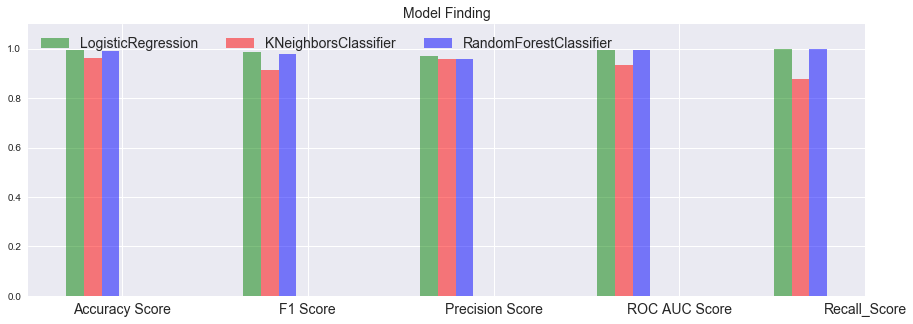

In [67]:
%matplotlib inline
model_finding2 = pd.DataFrame({'Accuracy Score':model_finding['Accuracy Score'].tolist(),
                                  'Precision Score':model_finding['Precision Score'].tolist(),
                                  'Recall_Score':model_finding['Recall_Score'].tolist(),
                                  'F1 Score':model_finding['F1 Score'].tolist(),
                                  'ROC AUC Score':model_finding['ROC AUC Score'].tolist()}
                              ,index = ['LogisticRegression','KNeighborsClassifier','RandomForestClassifier'])
model_finding2 = model_finding2.T

plt.figure(figsize=(15,5)).add_subplot()
width = 0.2;
xloc = np.array(range(len(model_finding2.index)+2))
adjloc = xloc[1:-1]-width

plt.bar(adjloc*8,model_finding2['LogisticRegression'], color = 'green', alpha = 0.5, label=model_finding2['LogisticRegression'].name)
plt.bar(adjloc*8+width*4,model_finding2['KNeighborsClassifier'], color = 'red', alpha = 0.5, label=model_finding2['KNeighborsClassifier'].name)
plt.bar(adjloc*8+width*8,model_finding2['RandomForestClassifier'], color = 'blue', alpha = 0.5, label=model_finding2['RandomForestClassifier'].name)

plt.xticks(xloc[1:-1]+width*8+adjloc*7.4,model_finding2.index,size = 14)
plt.yticks(size=10)
plt.ylim(0,1.1)
plt.legend(fontsize = 14, loc = 2, ncol=6)
plt.title("Model Finding", size = 14)



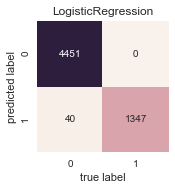

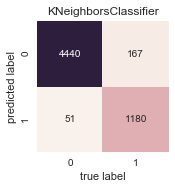

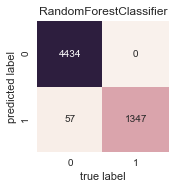

In [68]:
#confusion matrix
%matplotlib inline

#training test set
i=1
for name, models in zip(model_finding['Model Name'],model_finding['Model']):
    plt.figure(figsize=(8,10)).add_subplot(1,len(model_finding['Model Name']),i)
    yfit = models.predict(X_test_SC_scaled)
    mat = confusion_matrix(y_flights_test, yfit)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels=np.unique(y_flights_test),
        yticklabels=np.unique(y_flights_test))
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.title(name)
    i = i + 1


<a name = "7"></a>
## 7. Finding
<a name = "7A"></a>
### <font color='#7a1cff'>Case A - Prediction of flight delay for San Francisco International Airport and Los Angeles International Airport </font>

In our case of prediction, the result for:
 - True Positive (**TP**) --> correctly predicting delay flight.
 - False Negative (**FN**) --> incorrectly predicting delay flight as 'non delay flight'.
 - True Negative (**TN**) --> correctly predicting non delay flight.
 - False Positive (**FP**) --> incorrectly predicting non delay flight as 'delay flight'

Holiday schedule & plan will rely our this prediction. Hence, if it is predicted non delay but actual is delay might screw up the initial schedule.

On the other hand, if our prediction of flight delay but actual it is not will be added bonus. This will be more likely the scenario that we preferred.

Our preferred scenario explains the **FN** case, which is related to **recall**. 

$$\begin{eqnarray*}
\mbox{recall} &=& { TP / (TP + FN) }
\end{eqnarray*}$$

Our "not preferred" scenario explains the **FP** case, which is related to **precision**.

$$\begin{eqnarray*}
\mbox{precision} &=& { TP / (TP + FP) }
\end{eqnarray*}$$

We proposed to use recall as our primary metrics for selection of our final model. Therefore we will go for logistic regression  modeling for flight delay prediction.
   

<font size = 1> [home](#home) </font>